In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tools import data as d

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [23]:
def getColFromRow(row, namedData):
    hexStrVal = ''.join([row[cols[namedData][0]+x] for x in range(0, cols[namedData][1])])
    return hexStrVal;


def loadFromBin(df, fileUri):
    file = open(fileUri, "rb")

    byteRead = file.read(36)
    while byteRead:
        crc = d.getCRC(byteRead)

        if crc == '00':
            row = (''.join(format(x, '02x') for x in byteRead)).upper()

            splitRow = [row[i:i+2] for i in range(0, len(row), 2)]
            
            data = {}            
            for i in range(0, len(splitRow)):
                data['C' + str(i+1)] = splitRow[i+0]

            df = df.append(data, ignore_index=True)

        else:
            print("Bad CRC")
            display(byteRead)

        byteRead = file.read(36)

    file.close()
    
    return df;


def parseData(df, dfData):
    df = df.iloc[0:0]
    
    for i, row in enumerate(dfData.itertuples(), 1):
        stateA = d.getIntLE(getColFromRow(row, "stateA"))

        energyGauge = d.getIntLE(getColFromRow(row, "energyGauge"))
        unknownA = d.getIntLE(getColFromRow(row, "unknownA"))

        tempA = d.getIntLE(getColFromRow(row, "tempA"))
        tempB = d.getIntLE(getColFromRow(row, "tempB"))
        tempC = d.getIntLE(getColFromRow(row, "tempC"))
        tempD = d.getIntLE(getColFromRow(row, "tempD"))
        tempFA = d.getFahrenheit(tempA)
        tempFB = d.getFahrenheit(tempB)
        tempFC = d.getFahrenheit(tempC)
        tempFD = d.getFahrenheit(tempD)

        unknownB = d.getIntLE(getColFromRow(row, "unknownB"))

        totalVoltage = round(d.getIntLE(getColFromRow(row, "totalVoltage")) / 1000, 2)
        totalCurrent = round(d.getIntLE(getColFromRow(row, "totalCurrent")) / 1000, 2)
        
        totalCalculatedWatts  = round(totalVoltage * totalCurrent, 2)
        
        cellVoltageHigh = round(d.getIntLE(getColFromRow(row, "cellVoltageHigh")) / 1000, 2)
        cellVoltageLow = round(d.getIntLE(getColFromRow(row, "cellVoltageLow")) / 1000, 2)
        chargingState = 'ON' if d.getIntLE(getColFromRow(row, "chargingState")) < 0xFF else 'OFF'
        
        unknownC = round(d.getIntLE(getColFromRow(row, "unknownC")) / 1000, 2)

        df = df.append({
            'stateA':stateA,
###############
# New Insight #
###############
            'energyGauge':energyGauge,
###############
            'unknownA':unknownA,
            'tempA':tempA,
            'tempB':tempB,
            'tempC':tempC,
            'tempD':tempD,
            'tempFA':tempFA,
            'tempFB':tempFB,
            'tempFC':tempFC,
            'tempFD':tempFD,
            'unknownB':unknownB,
            'totalVoltage':totalVoltage,
            'totalCurrent':totalCurrent,
            
            'totalCalculatedWatts':totalCalculatedWatts,
            
            'cellVoltageHigh':cellVoltageHigh,
            'cellVoltageLow':cellVoltageLow,
###############
# New Insight #
###############
            'chargingState':chargingState,
###############
            'unknownC':unknownC,
        }, ignore_index=True)

    return df;


def formattedParseData(df):
    formattedDf = df.copy()
    
    del formattedDf['tempFA']
    del formattedDf['tempFB']
    del formattedDf['tempFC']
    del formattedDf['tempFD']

    formattedDf = formattedDf[['energyGauge','tempA','tempB','tempC','tempD','totalVoltage','totalCurrent','totalCalculatedWatts','cellVoltageHigh','cellVoltageLow','chargingState','stateA','unknownA','unknownB','unknownC']]

    formattedDf['energyGauge'] = formattedDf['energyGauge'].map('{:,d}%'.format)

    formattedDf['tempA'] = formattedDf['tempA'].map('{:,d}° C'.format)
    formattedDf['tempB'] = formattedDf['tempB'].map('{:,d}° C'.format)
    formattedDf['tempC'] = formattedDf['tempC'].map('{:,d}° C'.format)
    formattedDf['tempD'] = formattedDf['tempD'].map('{:,d}° C'.format)

    formattedDf['totalVoltage'] = formattedDf['totalVoltage'].map('{:,.2f} Vdc'.format)
    formattedDf['totalCurrent'] = formattedDf['totalCurrent'].map('{:,.2f} A'.format)
    formattedDf['totalCalculatedWatts'] = formattedDf['totalCalculatedWatts'].map('{:,.2f} W'.format)

    formattedDf['cellVoltageHigh'] = formattedDf['cellVoltageHigh'].map('{:,.2f} Vdc'.format)
    formattedDf['cellVoltageLow'] = formattedDf['cellVoltageLow'].map('{:,.2f} Vdc'.format)
    
    return formattedDf;



def colorColumn(dat, c='red'):
    return [f'background-color: {c}' for i in dat]


def formatDataToStyle(df):
    style = df.style
    
    for idx, val in enumerate(cols):
        subset = ['C'+str(cols[val][0]+k) for k in range(0, cols[val][1])]
        style = style.apply(colorColumn, axis=0, subset=subset, c=cols[val][2])

    # Determin if there was a data change from the previous column value:
    # - Ignore the first row (0)
    # - Ignore the last column (C36)
    style.apply(lambda x: [
        "background-color: #FFFFBD;border:2px solid #353500;" if (i > 0 and x.name != 'C36' and (v != x.iloc[i-1])) 
        else "" for i, v in enumerate(x)], axis = 0)

    return style;


In [24]:
cols = {
    "stateA": [4, 1, '#80FF00'],
    
    "energyGauge": [6, 1, '#CC66CC'], ## 0x00-0x64 (0-100 %)
    "unknownA": [7, 1, '#FF99FF'],

    "tempA": [8, 1, '#CCFFCC'],
    "tempB": [9, 1, '#CCFFCC'],
    "tempC": [10, 1, '#CCFFCC'],
    "tempD": [11, 1, '#CCFFCC'],

    "unknownB": [12, 1, '#FF99FF'],

    "totalVoltage": [22, 2, '#CCFFCC'],
    "totalCurrent": [26, 2, '#FFCCCC'],
    "chargingState": [28, 2, '#CCCCCFF'],
    "cellVoltageHigh": [30, 2, '#AAFFAA'],
    "cellVoltageLow": [32, 2, '#FFAAAA'],

    "unknownC": [34, 2, '#FF99FF'],

    "crc": [36, 1, '#AAAAAA'],
}

colsSizes = {}
for idx, val in enumerate(cols):
    colsSizes[val] = [cols[val][0], cols[val][0]+cols[val][1]-1]

In [25]:
dfData = pd.DataFrame([], columns=[
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
    'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
    'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
    'C31', 'C32', 'C33', 'C34', 'C35', 'C36'
])

dfDataB = pd.DataFrame([], columns=[
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
    'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
    'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
    'C31', 'C32', 'C33', 'C34', 'C35', 'C36'
])

dfProcessed = pd.DataFrame([], columns=[
    'stateA',

    'energyGauge',
    'unknownA',
    
    'tempA',
    'tempB',
    'tempC',
    'tempD',
    'tempFA',
    'tempFB',
    'tempFC',
    'tempFD',

    'unknownB',
    
    'totalVoltage',
    'totalCurrent',
    # Calculated by totalVoltage x totalCurrent = totalCalculatedWatts
    'totalCalculatedWatts',
    
    'cellVoltageHigh',
    'cellVoltageLow',

    'chargingState',
    
    'unknownC',
])

In [26]:
dfData = dfData.iloc[0:0]

dfData = loadFromBin(dfData, fileUri = "../Data/quickTest1--bat02.bin") # Discharging

# dfData = loadFromBin(dfData, fileUri = "../Data/quickTest1.bin") # Discharging
# dfData = loadFromBin(dfData, fileUri = "../Data/quickTest2.bin") # Discharging
# dfData = loadFromBin(dfData, fileUri = "../Data/quickTest3.bin") # Discharging

# dfData = loadFromBin(dfData, fileUri = "../Data/sample1.bin") # Discharging
# dfData = loadFromBin(dfData, fileUri = "../Data/sample2.bin") # Discharging
# dfData = loadFromBin(dfData, fileUri = "../Data/sample3.bin") # Discharging
# dfData = loadFromBin(dfData, fileUri = "../Data/sample4.bin") # Discharging
# dfData = loadFromBin(dfData, fileUri = "../Data/sample5.bin") # Depleated battery BMS shut down
# dfData = loadFromBin(dfData, fileUri = "../Data/sample6.bin") # Charging -> Charged

In [27]:
dfDataB = dfDataB.iloc[0:0]

# dfDataB = loadFromBin(dfData, fileUri = "../Data/quickTest1--bat02.bin") # Discharging

dfDataB = loadFromBin(dfData, fileUri = "../Data/quickTest1.bin") # Discharging
# dfDataB = loadFromBin(dfData, fileUri = "../Data/quickTest2.bin") # Discharging
# dfDataB = loadFromBin(dfData, fileUri = "../Data/quickTest3.bin") # Discharging

# dfDataB = loadFromBin(dfData, fileUri = "../Data/sample1.bin") # Discharging
# dfDataB = loadFromBin(dfData, fileUri = "../Data/sample2.bin") # Discharging
# dfDataB = loadFromBin(dfData, fileUri = "../Data/sample3.bin") # Discharging
# dfDataB = loadFromBin(dfData, fileUri = "../Data/sample4.bin") # Discharging
# dfDataB = loadFromBin(dfData, fileUri = "../Data/sample5.bin") # Depleated battery BMS shut down
# dfDataB = loadFromBin(dfData, fileUri = "../Data/sample6.bin") # Charging -> Charged

In [28]:
display(formatDataToStyle(dfData))

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36
0,3A,16,20,02,00,64,64,18,18,18,1A,23,00,00,0F,00,00,00,00,20,00,A0,A0,00,00,F0,FF,FF,FF,1A,10,08,10,52,2C,48
1,3A,16,20,02,00,64,64,18,18,18,1A,23,00,00,0F,00,00,00,00,20,00,9F,A0,00,00,F0,FF,FF,FF,19,10,08,10,52,2C,A3
2,3A,16,20,02,00,64,64,18,18,18,1A,23,00,00,0F,00,00,00,00,20,00,A0,A0,00,00,F0,FF,FF,FF,1A,10,08,10,52,2C,48
3,3A,16,20,02,00,64,64,18,18,18,1A,23,00,00,0F,00,00,00,00,20,00,A0,A0,00,00,F0,FF,FF,FF,1A,10,08,10,52,2C,48
4,3A,16,20,02,00,64,64,18,18,18,1A,23,00,00,0F,00,00,00,00,20,00,A4,9E,00,00,F1,F2,FF,FF,E6,0F,D9,0F,52,2C,D1
5,3A,16,20,02,00,64,64,18,18,18,1A,23,00,00,0F,00,00,00,00,20,00,39,9F,00,00,E6,F7,FF,FF,F6,0F,E7,0F,52,2C,AA
6,3A,16,20,02,00,64,64,18,18,18,1A,23,00,00,0F,00,00,00,00,20,00,2D,9F,00,00,D6,F7,FF,FF,F5,0F,E5,0F,52,2C,62
7,3A,16,20,02,00,64,64,18,18,18,1A,23,00,00,0F,00,00,00,00,20,00,22,9F,00,00,D0,F7,FF,FF,F3,0F,E4,0F,52,2C,74


In [29]:
display(formatDataToStyle(dfDataB))

In [30]:
dfProcessed = parseData(dfProcessed, dfData)
display(dfProcessed)

,stateA,energyGauge,unknownA,tempA,tempB,tempC,tempD,tempFA,tempFB,tempFC,tempFD,unknownB,totalVoltage,totalCurrent,totalCalculatedWatts,cellVoltageHigh,cellVoltageLow,chargingState,unknownC
0,2,100,100,24,24,24,26,75.2,75.2,75.2,78.8,35,41.12,65.52,2694.18,4.12,4.10,OFF,11.35
1,2,100,100,24,24,24,26,75.2,75.2,75.2,78.8,35,41.12,65.52,2694.18,4.12,4.10,OFF,11.35
2,2,100,100,24,24,24,26,75.2,75.2,75.2,78.8,35,41.12,65.52,2694.18,4.12,4.10,OFF,11.35
3,2,100,100,24,24,24,26,75.2,75.2,75.2,78.8,35,41.12,65.52,2694.18,4.12,4.10,OFF,11.35
4,2,100,100,24,24,24,26,75.2,75.2,75.2,78.8,35,40.61,62.19,2525.54,4.07,4.06,OFF,11.35
5,2,100,100,24,24,24,26,75.2,75.2,75.2,78.8,35,40.76,63.46,2586.63,4.09,4.07,OFF,11.35
6,2,100,100,24,24,24,26,75.2,75.2,75.2,78.8,35,40.75,63.45,2585.59,4.08,4.07,OFF,11.35
7,2,100,100,24,24,24,26,75.2,75.2,75.2,78.8,35,40.74,63.44,2584.55,4.08,4.07,OFF,11.35


In [31]:
display(formattedParseData(dfProcessed))

,energyGauge,tempA,tempB,tempC,tempD,totalVoltage,totalCurrent,totalCalculatedWatts,cellVoltageHigh,cellVoltageLow,chargingState,stateA,unknownA,unknownB,unknownC
0,100%,24° C,24° C,24° C,26° C,41.12 Vdc,65.52 A,"2,694.18 W",4.12 Vdc,4.10 Vdc,OFF,2,100,35,11.35
1,100%,24° C,24° C,24° C,26° C,41.12 Vdc,65.52 A,"2,694.18 W",4.12 Vdc,4.10 Vdc,OFF,2,100,35,11.35
2,100%,24° C,24° C,24° C,26° C,41.12 Vdc,65.52 A,"2,694.18 W",4.12 Vdc,4.10 Vdc,OFF,2,100,35,11.35
3,100%,24° C,24° C,24° C,26° C,41.12 Vdc,65.52 A,"2,694.18 W",4.12 Vdc,4.10 Vdc,OFF,2,100,35,11.35
4,100%,24° C,24° C,24° C,26° C,40.61 Vdc,62.19 A,"2,525.54 W",4.07 Vdc,4.06 Vdc,OFF,2,100,35,11.35
5,100%,24° C,24° C,24° C,26° C,40.76 Vdc,63.46 A,"2,586.63 W",4.09 Vdc,4.07 Vdc,OFF,2,100,35,11.35
6,100%,24° C,24° C,24° C,26° C,40.75 Vdc,63.45 A,"2,585.59 W",4.08 Vdc,4.07 Vdc,OFF,2,100,35,11.35
7,100%,24° C,24° C,24° C,26° C,40.74 Vdc,63.44 A,"2,584.55 W",4.08 Vdc,4.07 Vdc,OFF,2,100,35,11.35


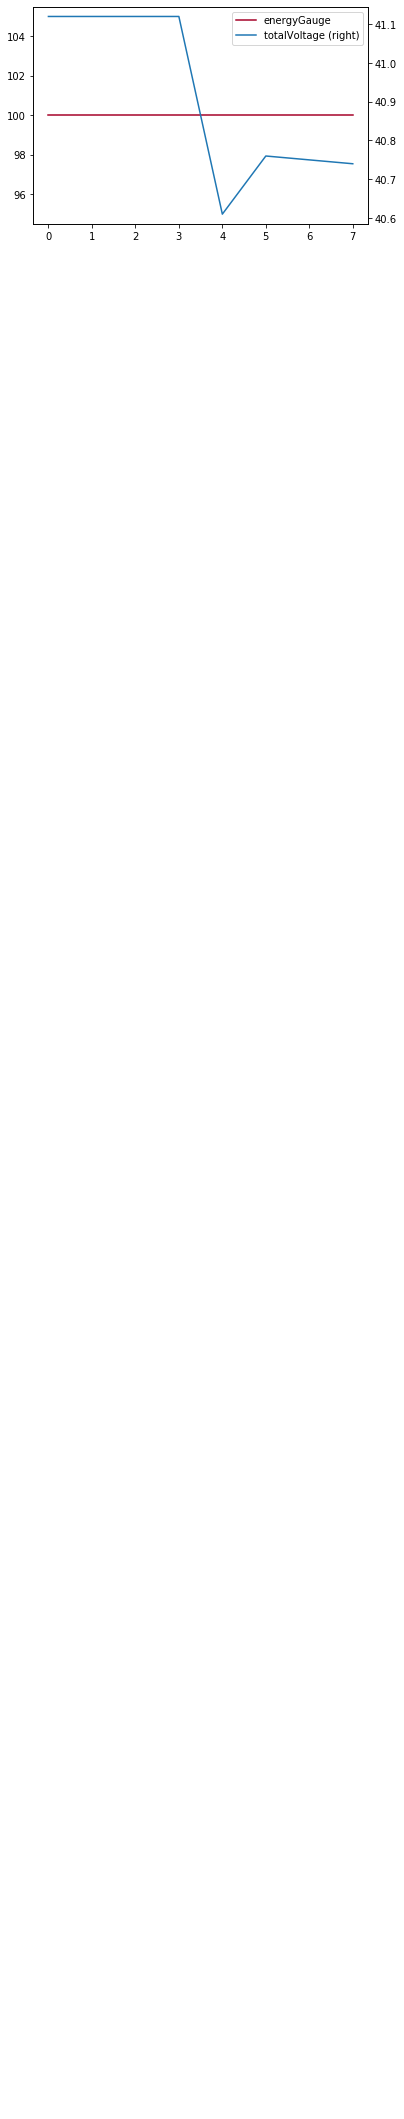

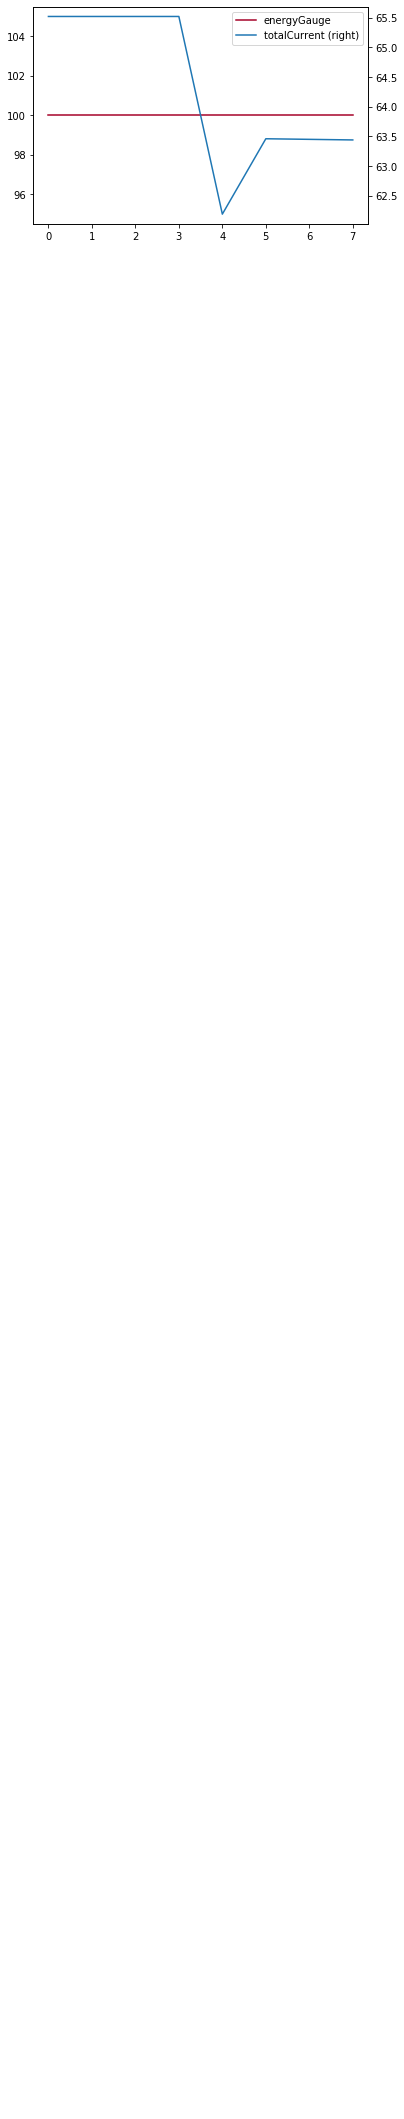

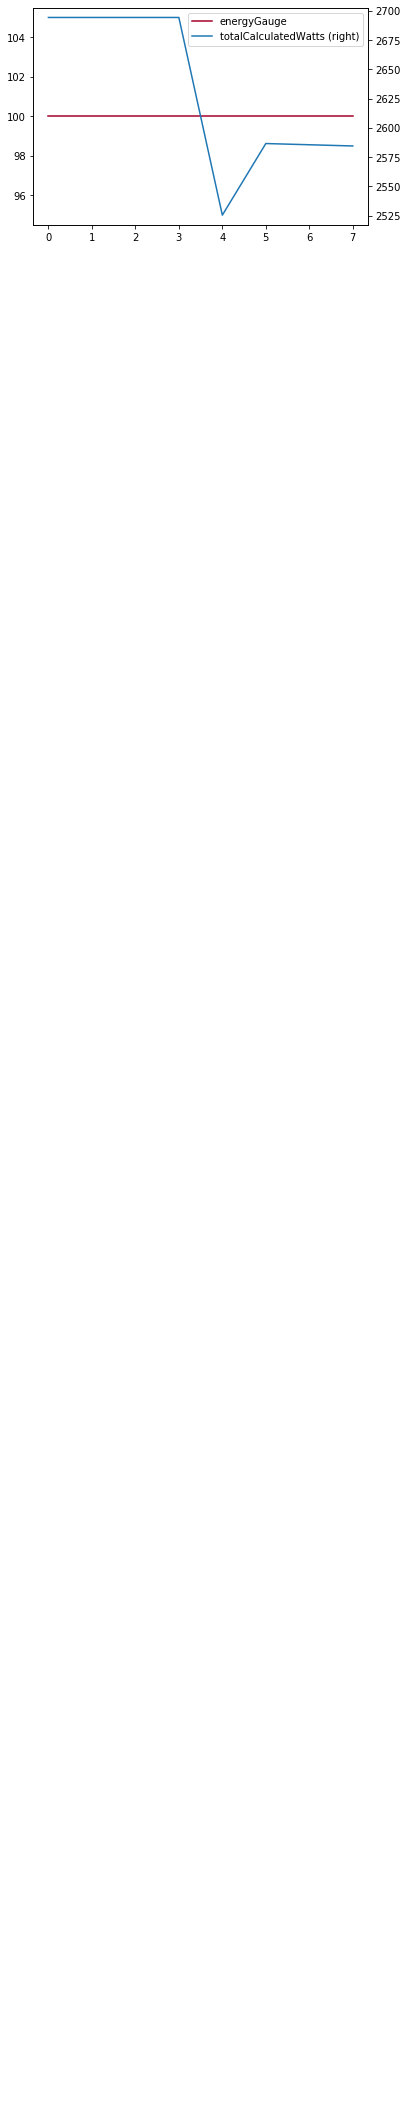

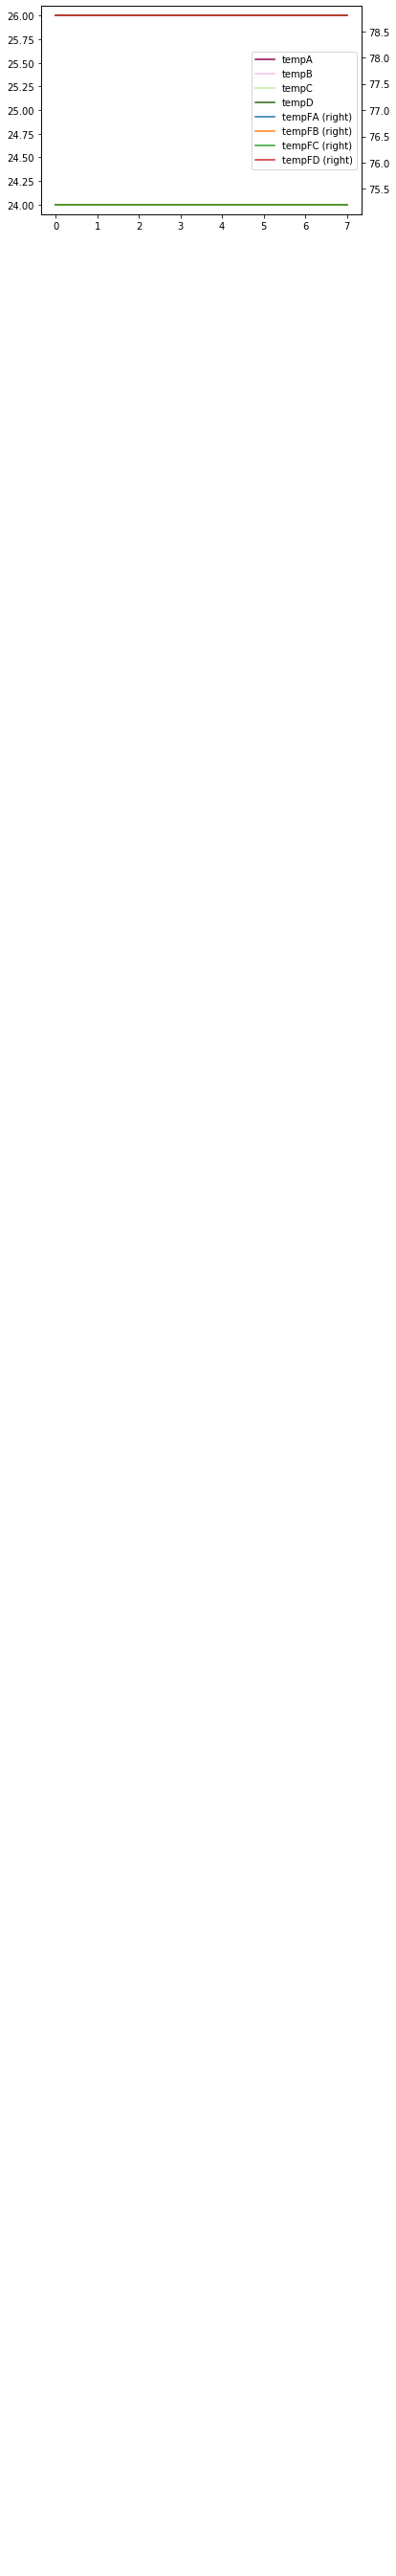

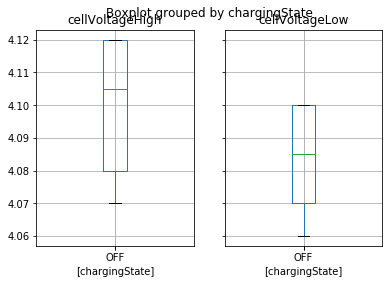

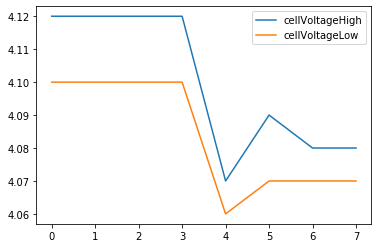

In [35]:
def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

startChargeCell = dfData.loc[dfData['C29'] == '00'].head(1)
startChargeIdx = startChargeCell.index
startChargeIdxVal = startChargeIdx.astype(int)[0] if len(startChargeIdx) > 0 else -1

endChargeCell = dfData.loc[(dfData['C6'] == '64') & (dfData['C20'] != '00') & (dfData['C29'] == 'FF')].head(1) 
endChargeIdx = endChargeCell.index
endChargeIdxVal = endChargeIdx.astype(int)[0] if len(endChargeIdx) > 0 else -1

if len(startChargeIdx) > 0 | len(endChargeIdx) > 0:
    ## Energy Based
    if len(startChargeIdx) > 0 & len(endChargeIdx) > 0:
        energyGuageCell = dfProcessed.loc[max([startChargeIdx, endChargeIdx])]
    elif len(startChargeIdx) > 0:
        energyGuageCell = dfProcessed.loc[startChargeIdx]
    else:
        energyGuageCell = dfProcessed.loc[endChargeIdx]
    energyGuageVal = energyGuageCell['energyGauge'].astype(int).values

    minEnergyGuageVal = dfProcessed['energyGauge'].min()
    maxEnergyGuageVal = dfProcessed['energyGauge'].max()
    energyGuageBump = (energyGuageVal*.005)
    energyGuagePlotPosYArrow = clamp(energyGuageVal + (energyGuageBump), minEnergyGuageVal, maxEnergyGuageVal)
    if energyGuagePlotPosYArrow / maxEnergyGuageVal <= .5:
        energyGuageBump = -energyGuageBump
        energyGuagePlotPosYArrow = clamp(energyGuageVal + (energyGuageBump), minEnergyGuageVal, maxEnergyGuageVal)
    energyGuagePlotPosYText = clamp(energyGuageVal + (energyGuageBump*3), minEnergyGuageVal, maxEnergyGuageVal)

    ## Temp Based
    if len(startChargeIdx) > 0 & len(endChargeIdx) > 0:
        tempCell = dfProcessed.loc[max([startChargeIdx, endChargeIdx])]
    elif len(startChargeIdx) > 0:
        tempCell = dfProcessed.loc[startChargeIdx]
    else:
        tempCell = dfProcessed.loc[endChargeIdx]
    tempVal = max(tempCell["tempA"].astype(int).values, tempCell["tempB"].astype(int).values, tempCell["tempC"].astype(int).values, tempCell["tempD"].astype(int).values)

    minTempVal = dfProcessed[["tempA", "tempB", "tempC", "tempD"]].max(axis=1).min()
    maxTempVal = dfProcessed[["tempA", "tempB", "tempC", "tempD"]].max(axis=1).max()
    tempBump = (tempVal*.035)
    tempPlotPosYArrow = clamp(tempVal + (tempBump), minTempVal, maxTempVal)
    if tempPlotPosYArrow / maxTempVal <= .5:
        tempBump = -tempBump
        tempPlotPosYArrow = clamp(tempVal + (tempBump), minTempVal, maxTempVal)
    tempPlotPosYText = clamp(tempVal + (tempBump*3), minTempVal, maxTempVal)
else:
    energyGuageBump = 0
    energyGuageVal = -1
    energyGuagePlotPosYArrow = -1
    energyGuagePlotPosYText = -1
    tempBump = 0
    tempVal = -1
    tempPlotPosYArrow = -1
    tempPlotPosYText = -1


ax = dfProcessed.plot(y='energyGauge', kind='line', colormap='RdYlGn')
dfProcessed.plot(ax=ax, y='totalVoltage', secondary_y=True, kind='line')
if startChargeIdxVal >= 0:
    ax.annotate('Start Charge', xy=(startChargeIdxVal, energyGuagePlotPosYArrow), xytext=(startChargeIdxVal, energyGuagePlotPosYText),
                ha='center', va='bottom', color='blue',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle="->", color="g", connectionstyle="arc3,rad=.55"))
if endChargeIdxVal >= 0:
    ax.annotate('Full Charge', xy=(endChargeIdxVal, energyGuagePlotPosYArrow + (energyGuageBump * 2)), xytext=(endChargeIdxVal, energyGuagePlotPosYText + (energyGuageBump * 2)),
                ha='center', va='bottom', color='blue',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle="->", color="g", connectionstyle="arc3,rad=.55"))
plt.show()


ax = dfProcessed.plot(y='energyGauge', kind='line', colormap='RdYlGn')
dfProcessed.plot(ax=ax, y='totalCurrent', secondary_y=True, kind='line')
if startChargeIdxVal >= 0:
    ax.annotate('Start Charge', xy=(startChargeIdxVal, energyGuagePlotPosYArrow), xytext=(startChargeIdxVal, energyGuagePlotPosYText),
                ha='center', va='bottom', color='blue',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle="->", color="g", connectionstyle="arc3,rad=.55"))
if endChargeIdxVal >= 0:
    ax.annotate('Full Charge', xy=(endChargeIdxVal, energyGuagePlotPosYArrow + (energyGuageBump * 2)), xytext=(endChargeIdxVal, energyGuagePlotPosYText + (energyGuageBump * 2)),
                ha='center', va='bottom', color='blue',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle="->", color="g", connectionstyle="arc3,rad=.55"))
plt.show()


ax = dfProcessed.plot(y='energyGauge', kind='line', colormap='RdYlGn')
dfProcessed.plot(ax=ax, y='totalCalculatedWatts', secondary_y=True, kind='line')
if startChargeIdxVal >= 0:
    ax.annotate('Start Charge', xy=(startChargeIdxVal, energyGuagePlotPosYArrow), xytext=(startChargeIdxVal, energyGuagePlotPosYText),
                ha='center', va='bottom', color='blue',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle="->", color="g", connectionstyle="arc3,rad=.55"))
if endChargeIdxVal >= 0:
    ax.annotate('Full Charge', xy=(endChargeIdxVal, energyGuagePlotPosYArrow + (energyGuageBump * 2)), xytext=(endChargeIdxVal, energyGuagePlotPosYText + (energyGuageBump * 2)),
                ha='center', va='bottom', color='blue',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle="->", color="g", connectionstyle="arc3,rad=.55"))
plt.show()


ax = dfProcessed.plot(y=['tempA', 'tempB', 'tempC', 'tempD'], kind = 'line', colormap='PiYG')
dfProcessed.plot(ax=ax, y=['tempFA', 'tempFB', 'tempFC', 'tempFD'], kind = 'line', secondary_y=True)
if startChargeIdxVal >= 0:
    ax.annotate('Start Charge', xy=(startChargeIdxVal, tempPlotPosYArrow), xytext=(startChargeIdxVal, tempPlotPosYText),
                ha='center', va='bottom', color='blue',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle="->", color="g", connectionstyle="arc3,rad=.55"))
if endChargeIdxVal >= 0:
    ax.annotate('Full Charge', xy=(endChargeIdxVal, tempPlotPosYArrow + (tempBump * 2)), xytext=(endChargeIdxVal, tempPlotPosYText + (tempBump * 2)),
                ha='center', va='bottom', color='blue',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle="->", color="g", connectionstyle="arc3,rad=.55"))
plt.show()


color = {
    "boxes": "DarkGreen",
    "whiskers": "DarkOrange",
    "medians": "DarkBlue",
    "caps": "Gray",
}
dfProcessed.boxplot(column=["cellVoltageHigh", "cellVoltageLow"], by=["chargingState"]);
plt.show()


ax = dfProcessed.plot(y=['cellVoltageHigh', 'cellVoltageLow'], kind = 'line')
plt.show()

### Distinct Column Values

In [33]:
display(dfData['C5'].unique())

array(['00'], dtype=object)